In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6], preprocess=True)
systems = set([x['system'] for x in data])
edit_types = set(data[0]['annotations'].keys())

# TODO: trivial edits on substitutions aren't being processed correctly

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'anton', 'rachel', 'vishnesh', 'kelly', 'ayush'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

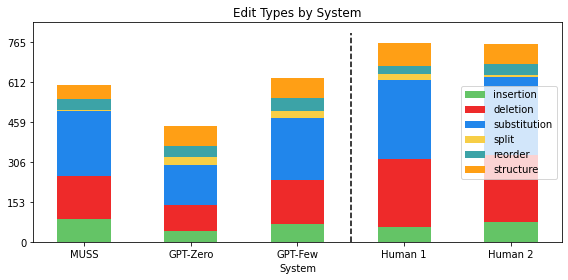

In [2]:
edit_type_by_system(data)

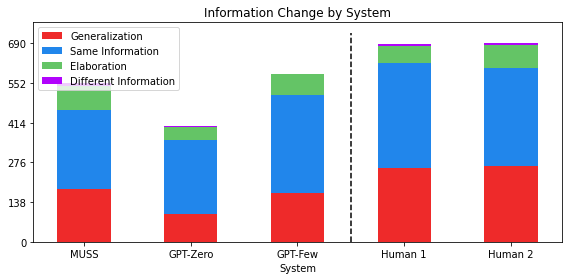

In [3]:
system_by_information_change(data)

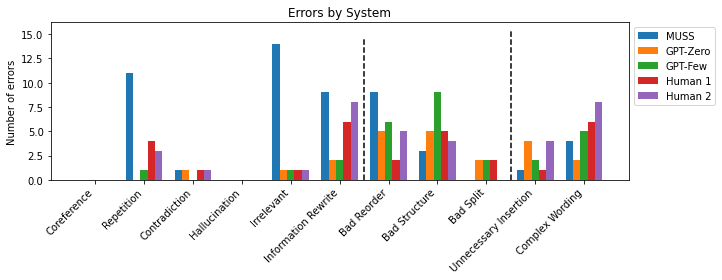

In [4]:
errors_by_system(data)

In [5]:
sankey_combined(data)

In [6]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

GPT-Zero 	 5.69
Human 2 	 10.46
Human 1 	 9.02
MUSS 	 3.46
GPT-Few 	 8.68


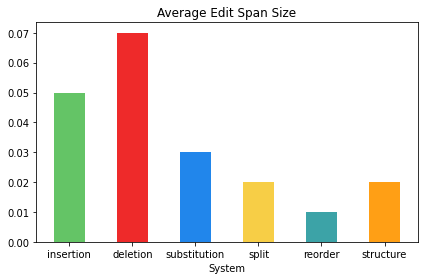

In [7]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

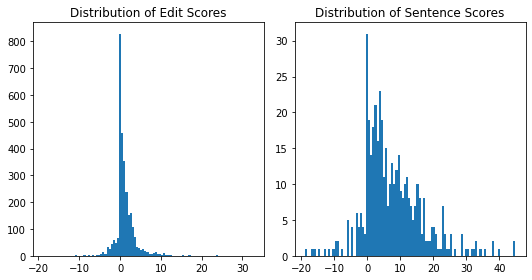

In [8]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [9]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
vishnesh - Batch 6, HIT 32 (ID 130) - 44.74048122070516
vinayak - Batch 6, HIT 16 (ID 45) - 44.49183097534004
anton - Batch 5, HIT 40 (ID 39) - 40.218971182996725
vinayak - Batch 5, HIT 7 (ID 95) - 38.370866195271674
kelly - Batch 5, HIT 16 (ID 42) - 38.017761293449254

Lowest scoring:
anton - Batch 5, HIT 29 (ID 28) - -18.858700167805132
anton - Batch 6, HIT 16 (ID 114) - -16.69249648750433
anton - Batch 5, HIT 25 (ID 24) - -15.77741900496934
ayush - Batch 6, HIT 2 (ID 135) - -14.600727188758242
anton - Batch 6, HIT 29 (ID 127) - -12.7650672868958


In [10]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 5, HIT 19 (ID 18)
ayush - Batch 5, HIT 14 (ID 18)
vinayak - Batch 6, HIT 10 (ID 72)


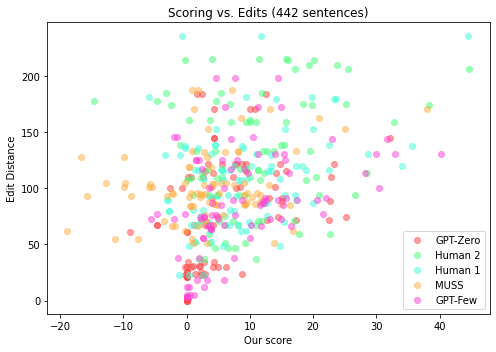

In [11]:
# average_scores: Averages our scores before plotting
edit_length(data, systems, simpeval=False, average_scores=False)

In [12]:
# Get sentences with at least 1 structure change from 1 annotator
ids = sorted(list(set([sent['id'] for sent in data if 'structure' in [x['type'] for x in sent['edits']]])))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 113 / 442


anton - Batch 5, HIT 6 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.

rachel - Batch 5, HIT 8 (ID 5)

In Marriages and Infidelities, Oates explicitly alludes to novellas and short stories by earlier writers, making use of either their titles or their themes and adapting them in accordance with her artistic intentions.
In "Marriages and Infidelities," Oates uses the titles and themes from earlier novellas and short stories and adapts them to match her own goals.



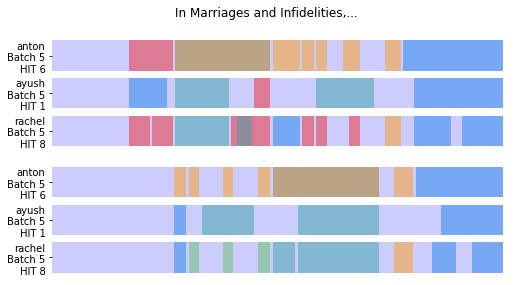

In [13]:
# Display a sentence with a structure change
id_ = 4
sents = [sent for sent in data if sent['id'] == ids[id_]]
print_changes(sents)
draw_agreement(sents)

In [14]:
for system in systems:
    aloe, aloe_no_del, perc_error = error_rate([sent for sent in data if system == sent['system']])
    print(f'''
    --- {system} ---
    Sentences with at least 1 error: {aloe}
    Sentences with at least 1 error excluding bad deletion: {aloe_no_del}
    Percentage of error edits: {perc_error}
    ''')


    --- new-wiki-1/GPT-3-zero-shot ---
    Sentences with at least 1 error: 0.3448275862068966
    Sentences with at least 1 error excluding bad deletion: 0.19540229885057472
    Percentage of error edits: 0.09975062344139651
    

    --- new-wiki-1/Human 2 Writing ---
    Sentences with at least 1 error: 0.5454545454545454
    Sentences with at least 1 error excluding bad deletion: 0.26136363636363635
    Percentage of error edits: 0.12427745664739884
    

    --- new-wiki-1/Human 1 Writing ---
    Sentences with at least 1 error: 0.5111111111111111
    Sentences with at least 1 error excluding bad deletion: 0.26666666666666666
    Percentage of error edits: 0.11773255813953488
    

    --- new-wiki-1/Muss ---
    Sentences with at least 1 error: 0.8045977011494253
    Sentences with at least 1 error excluding bad deletion: 0.5057471264367817
    Percentage of error edits: 0.22644927536231885
    

    --- new-wiki-1/GPT-3-few-shot ---
    Sentences with at least 1 error: 0.411111

In [15]:
# What % content edits are elaboration vs generalization

# Graphs each system with 6 columns each. Each column is a different quality edit. 
# This takes the average rating of each edit

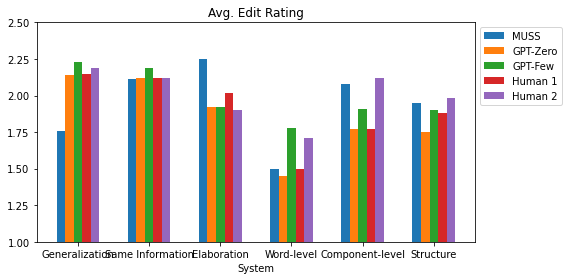

In [16]:
avg_edit_ratings(data)

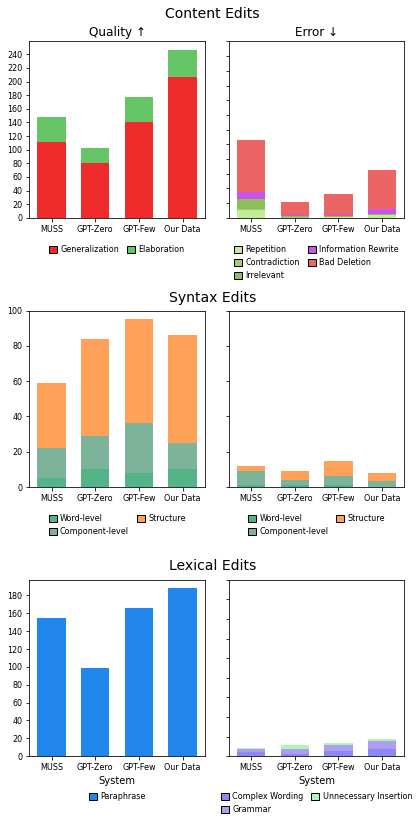

In [17]:
# Older version which combines graphs side-by-side
# edits_by_family(data)

# edits_by_family(data, Family.CONTENT)
# edits_by_family(data, Family.SYNTAX)
# edits_by_family(data, Family.LEXICAL)

edits_by_family_separated(data, savefig=True)
edits_by_family_separated(data)

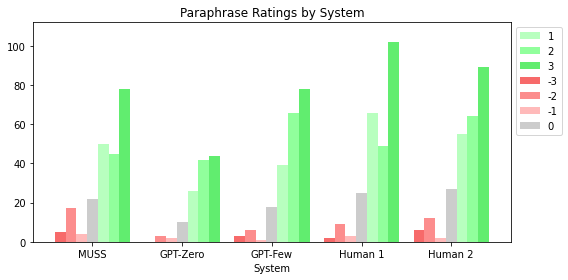

In [18]:
ratings_by_edit_type(data, 'paraphrase')
# ratings_by_edit_type(data, 'split')
# ratings_by_edit_type(data, 'reorder')
# ratings_by_edit_type(data, 'structure')

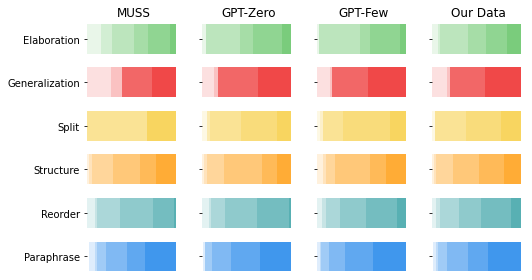

In [19]:
edit_ratings_barh(data, old_formatting=True)

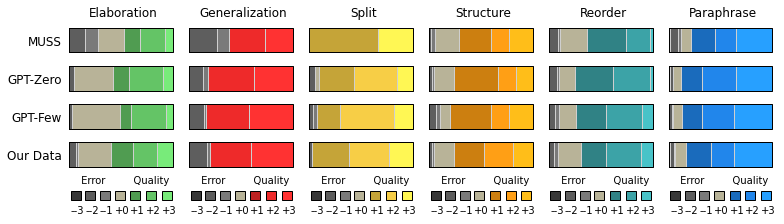

In [20]:
edit_ratings_barh(data)

In [21]:
# Prints a table quality edits
for family in ['elaboration', 'generalization', 'split', 'structure', 'reorder', 'paraphrase']:
    ratings = get_ratings_by_edit_type(data, family)
    al = f'{family} & '
    for system in [s for s in all_system_labels if s in ratings.keys() and '2' not in s]:
        total = sum([x if type(x) is int else sum(x.values()) for x in list(ratings[system].values())])
        nl = ""
        for i in range(3):
            nl += (f'{round(ratings[system]["error"][i] / total, 2)*100:.0f} & ')
        nl += (f'{round(ratings[system]["trivial"] / total, 2)*100:.0f} & ')
        for i in range(3):
            nl += (f'{round(ratings[system]["quality"][i] / total, 2)*100:.0f} & ')
        al += nl
    al = ' & ' + al[:-2].capitalize() + '\\tabularnewline'
    print(al)

 & Elaboration & 0 & 15 & 13 & 24 & 15 & 24 & 8 & 0 & 5 & 0 & 38 & 15 & 33 & 10 & 0 & 3 & 0 & 46 & 11 & 33 & 7 & 0 & 10 & 2 & 28 & 18 & 23 & 18 \tabularnewline
 & Generalization & 0 & 27 & 12 & 0 & 0 & 34 & 27 & 0 & 13 & 5 & 0 & 0 & 44 & 38 & 0 & 14 & 2 & 0 & 0 & 41 & 42 & 0 & 17 & 3 & 0 & 0 & 41 & 39 \tabularnewline
 & Split & 0 & 0 & 0 & 0 & 67 & 0 & 33 & 0 & 6 & 0 & 3 & 34 & 41 & 16 & 0 & 4 & 4 & 0 & 22 & 52 & 19 & 0 & 4 & 0 & 0 & 35 & 48 & 13 \tabularnewline
 & Structure & 0 & 2 & 4 & 23 & 31 & 17 & 23 & 0 & 3 & 3 & 19 & 42 & 16 & 16 & 0 & 7 & 4 & 9 & 39 & 18 & 23 & 0 & 3 & 1 & 17 & 28 & 36 & 14 \tabularnewline
 & Reorder & 0 & 9 & 3 & 26 & 37 & 23 & 3 & 0 & 8 & 3 & 15 & 36 & 36 & 3 & 0 & 6 & 4 & 16 & 29 & 35 & 10 & 0 & 3 & 3 & 37 & 30 & 20 & 7 \tabularnewline
 & Paraphrase & 2 & 8 & 2 & 10 & 23 & 20 & 35 & 2 & 2 & 0 & 8 & 20 & 33 & 35 & 0 & 3 & 1 & 9 & 18 & 31 & 37 & 1 & 4 & 1 & 10 & 26 & 19 & 40 \tabularnewline


In [22]:
# - Average quality edit (or log-size * average) rating for these modification types
#     - Content, Syntax, Lexical
#     - Elaboration, Generalization, Paraphrase, Structure, Reorder, Split
# - Average error edit for Content, Syntax, Lexical i guess?
# - Overlap the annotator’s decision for each system

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json', '../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'anton', 'rachel', 'vishnesh', 'kelly', 'ayush'}

anton - Batch 5, HIT 38 (ID 177) has 2 deletion edits but 1 annotations. Likely 

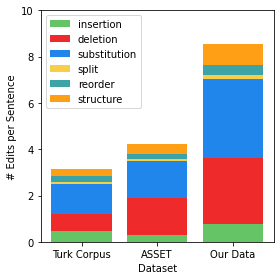

In [23]:
all_data = load_data('../annotated', preprocess=True)
edit_type_by_system(all_data, humans=True, normalized=True)